# WeatherPy

---

## Starter Code to Generate Random Geographic Coordinates and a List of Cities

In [137]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Impor the OpenWeatherMap API key
from api_keys import weather_api_key
print(weather_api_key)

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

8ccb1544e0456a35596f37de8faee786


### Generate the Cities List by Using the `citipy` Library

In [138]:
# Empty list for holding the latitude and longitude combinations
lat_lngs = []

# Empty list for holding the cities names
cities = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")
#shortcities = cities[0:100]
#print(shortcities)

Number of cities in the list: 600


---

## Requirement 1: Create Plots to Showcase the Relationship Between Weather Variables and Latitude

### Use the OpenWeatherMap API to retrieve weather data from the cities list generated in the started code

In [139]:
# Set the API base URL
url = "https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude={part}&appid={API_key}"

# Define an empty list to fetch the weather data for each city
city_data = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Loop through all the cities in our list to fetch weather data
for i, city in enumerate(cities):
        
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0

    # Create endpoint URL with each city
    #print(lats[i], lngs[i])
    mylats = lats[i]
    mylngs = lngs[i]
    city_url = url.format(lat = mylats, lon = mylngs, part = "hourly, daily", API_key = weather_api_key)
    #print(city_url)
    
    # Log the url, record, and set numbers
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Add 1 to the record count
    record_count += 1

    # Run a API request for each of the cities
    try:
        response = requests.get(city_url)
        #print(response)
        data = response.json()
        #print(data)
        city_weather = data["current"]["weather"][0]["main"] # The [0] here is because it seems like weather was a string? I call the first index of the string then can access the rest as a dict
        #print(city_weather)
        # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
        city_lat = data["lat"]
        #print(city_lat)
        city_lng = data["lon"]
        #print(city_lng)
        city_max_temp = data["daily"][0]["temp"]["max"] #again using the [0] trick. That was a weird one to figure out.
        city_max_temp = (city_max_temp - 273.15) * 1.8 + 32 # Converting from Kelvin to Farenheit because I got way through this exercise before realizing I should have used imperial. This is easy.
        #print(city_max_temp)
        city_humidity = data["daily"][0]["humidity"]
        #print(city_humidity)
        city_clouds = data["daily"][0]["clouds"]
        #print(city_clouds)
        city_wind = data["daily"][0]["wind_speed"]
        #print(city_wind)
        city_country = citipy.nearest_city(city_lat, city_lng).country_code # I had to use a city object in order to pull country, but i only had a list of cities as strings, so i re-create it here. Seems inefficient but I couldn't solve it otherwise.
        #print(city_country)
        city_date = data["current"]["dt"]
        #print(city_date)
        # Append the City information into city_data list
        city_data.append({"City": city, 
                          "Lat": city_lat, 
                          "Lng": city_lng, 
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})
    # If an error is experienced, skip the city
    except:
        print("City not found. Skipping...")
        pass


# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

print(city_data)

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | saint-georges
Processing Record 2 of Set 1 | soubre
Processing Record 3 of Set 1 | nogliki
Processing Record 4 of Set 1 | matagami
Processing Record 5 of Set 1 | isangel
Processing Record 6 of Set 1 | gueugnon
Processing Record 7 of Set 1 | cabo san lucas
Processing Record 8 of Set 1 | faanui
Processing Record 9 of Set 1 | avarua
Processing Record 10 of Set 1 | hobart
Processing Record 11 of Set 1 | punta arenas
Processing Record 12 of Set 1 | attawapiskat
Processing Record 13 of Set 1 | port alfred
Processing Record 14 of Set 1 | rikitea
Processing Record 15 of Set 1 | albany
Processing Record 16 of Set 1 | nizhneyansk
Processing Record 17 of Set 1 | tuktoyaktuk
Processing Record 18 of Set 1 | mahebourg
Processing Record 19 of Set 1 | sao jose da coroa grande
Processing Record 20 of Set 1 | gat
Processing Record 21 of Set 1 | bathsheba
Processing Record 22 of Set 1 | moba
Processing Record 23 of

In [140]:
# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame.from_dict(city_data)

# Show Record Count
city_data_df.count()

City          600
Lat           600
Lng           600
Max Temp      600
Humidity      600
Cloudiness    600
Wind Speed    600
Country       600
Date          600
dtype: int64

In [141]:
# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,saint-georges,5.3427,-47.8540,79.826,83,71,8.62,gf,1681170431
1,soubre,5.6404,-6.4534,90.428,52,100,2.61,ci,1681170431
2,nogliki,52.7893,144.7801,29.300,64,2,6.59,ru,1681170432
3,matagami,51.9601,-76.3846,36.446,100,100,6.00,ca,1681170433
4,isangel,-17.8039,171.7914,83.858,75,14,6.11,vu,1681170434


In [142]:
# Export the City_Data into a csv
city_data_df.to_csv("../output_data/cities.csv", index_label="City_ID")

In [143]:
# Read saved data
city_data_df = pd.read_csv("../output_data/cities.csv", index_col="City_ID")

# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,saint-georges,5.3427,-47.8540,79.826,83,71,8.62,gf,1681170431
1,soubre,5.6404,-6.4534,90.428,52,100,2.61,ci,1681170431
2,nogliki,52.7893,144.7801,29.300,64,2,6.59,ru,1681170432
3,matagami,51.9601,-76.3846,36.446,100,100,6.00,ca,1681170433
4,isangel,-17.8039,171.7914,83.858,75,14,6.11,vu,1681170434


### Create the Scatter Plots Requested

#### Latitude Vs. Temperature

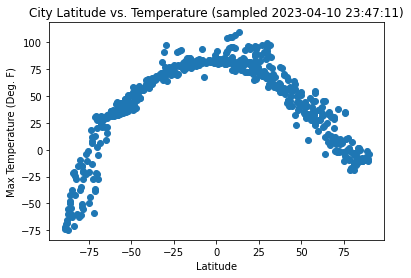

In [144]:
# Build scatter plot for latitude vs. temperature
plt.scatter(city_data_df["Lat"], city_data_df["Max Temp"], marker = "o")

# Incorporate the other graph properties
date_of_sample = pd.to_datetime(city_data_df["Date"], unit = "s")
min_date = date_of_sample.min()
plt.title(f"City Latitude vs. Temperature (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (Deg. F)")

# Save the figure
plt.savefig("../output_data/Fig1.png")

# Show plot
plt.show()

#### Latitude Vs. Humidity

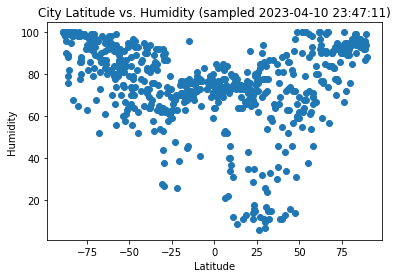

In [145]:
# Build the scatter plots for latitude vs. humidity
plt.scatter(city_data_df["Lat"], city_data_df["Humidity"], marker = "o")

# Incorporate the other graph properties

plt.title(f"City Latitude vs. Humidity (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity")

# Save the figure
plt.savefig("../output_data/Fig2.png")

# Show plot
plt.show()

#### Latitude Vs. Cloudiness

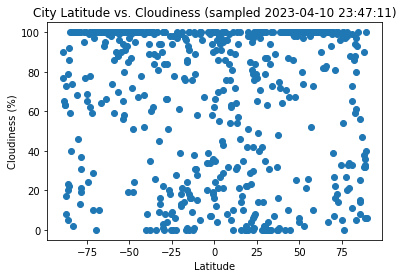

In [146]:
# Build the scatter plots for latitude vs. cloudiness
plt.scatter(city_data_df["Lat"], city_data_df["Cloudiness"], marker = "o")

# Incorporate the other graph properties

plt.title(f"City Latitude vs. Cloudiness (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Save the figure
plt.savefig("../output_data/Fig3.png")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

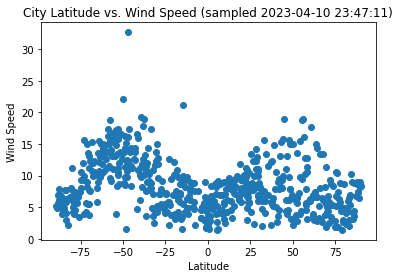

In [147]:
# Build the scatter plots for latitude vs. wind speed
plt.scatter(city_data_df["Lat"], city_data_df["Wind Speed"], marker = "o")

# Incorporate the other graph properties

plt.title(f"City Latitude vs. Wind Speed (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
# Save the figure
plt.savefig("../output_data/Fig4.png")

# Show plot
plt.show()

---

## Requirement 2: Compute Linear Regression for Each Relationship


r-value =  -0.02092581519485873


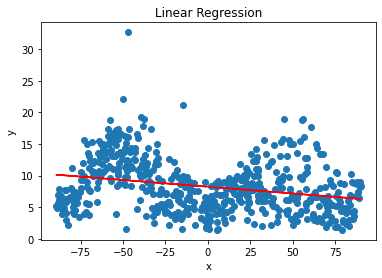

In [148]:
# Define a function to create Linear Regression plots
# YOUR CODE HERE
import math # this is a standard library and I need it for the square root functions

def linear_regression(x, y):
    n = len(x)
    x_mean = sum(x) / n
    y_mean = sum(y) / n
    # calculate R value
    x_stddev = math.sqrt(sum([(i - x_mean)**2 for i in x]) / (len(x) - 1))
    y_stddev = math.sqrt(sum([(i - y_mean)**2 for i in x]) / (len(y) - 1))
    covariance = sum([(x[i] - x_mean) * (y[i] - y_mean) for i in range(len(x))]) / (len(x) - 1)
    r_value = covariance / (x_stddev * y_stddev)
    print("r-value = ", r_value)
    # calculate slope and intercept for plotting
    slope = sum([(x[i] - x_mean) * (y[i] - y_mean) for i in range(n)]) / sum([(x[i] - x_mean) ** 2 for i in range(n)])
    intercept = y_mean - slope * x_mean
    
    # do the plotting
    plt.scatter(x, y)
    plt.plot(x, [slope * xi + intercept for xi in x], color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Linear Regression')
    plt.show()


linear_regression(city_data_df["Lat"], city_data_df["Wind Speed"])

In [149]:
# Create a DataFrame with the Northern Hemisphere data (Latitude >= 0)
northern_hemi_df = city_data_df[city_data_df["Lat"]>=0]
northern_hemi_df = northern_hemi_df.reset_index(drop=True)


# Display sample data
northern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,saint-georges,5.3427,-47.8540,79.826,83,71,8.62,gf,1681170431
1,soubre,5.6404,-6.4534,90.428,52,100,2.61,ci,1681170431
2,nogliki,52.7893,144.7801,29.300,64,2,6.59,ru,1681170432
3,matagami,51.9601,-76.3846,36.446,100,100,6.00,ca,1681170433
4,gueugnon,46.6601,4.1630,56.732,72,100,3.99,fr,1681170434


In [150]:
# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
southern_hemi_df = city_data_df[city_data_df["Lat"]<=0]
southern_hemi_df = southern_hemi_df.reset_index(drop=True)


# Display sample data
southern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,isangel,-17.8039,171.7914,83.858,75,14,6.11,vu,1681170434
1,faanui,-11.4482,-155.6564,82.994,72,99,4.93,pf,1681170436
2,avarua,-47.7267,-165.5481,57.524,78,100,9.69,ck,1681170436
3,hobart,-79.0086,140.2841,-53.428,86,13,6.98,au,1681170437
4,punta arenas,-73.6621,-104.1790,18.194,97,99,11.97,cl,1681170437


###  Temperature vs. Latitude Linear Regression Plot

r-value =  -1.1661751574236854


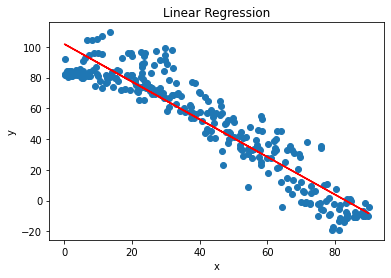

In [151]:
# Linear regression on Northern Hemisphere
linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Max Temp"])

r-value =  0.4403855384557437


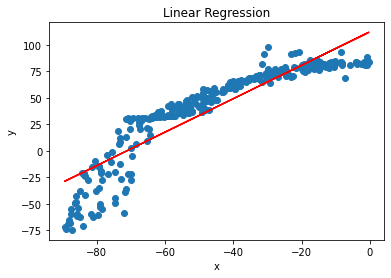

In [152]:
# Linear regression on Southern Hemisphere
linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Max Temp"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Humidity vs. Latitude Linear Regression Plot

r-value =  0.27196252653099734


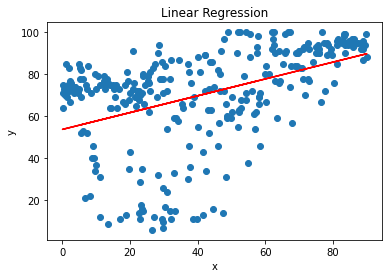

In [153]:
# Northern Hemisphere

linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Humidity"])

r-value =  -0.06336322710368163


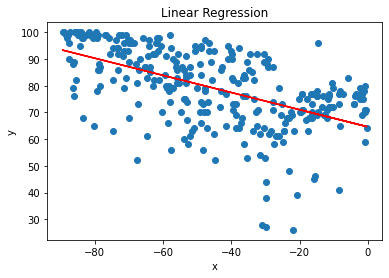

In [154]:
# Southern Hemisphere

linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Humidity"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Cloudiness vs. Latitude Linear Regression Plot

r-value =  0.09111017224574039


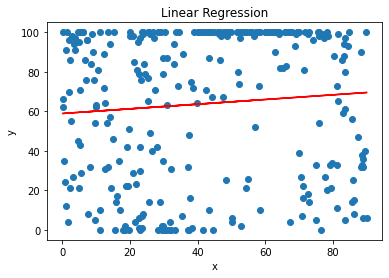

In [155]:
# Northern Hemisphere

linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Cloudiness"])

r-value =  -0.06336322710368163


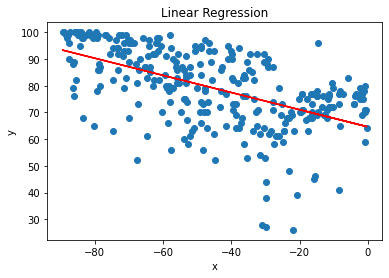

In [156]:
# Southern Hemisphere

linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Humidity"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Wind Speed vs. Latitude Linear Regression Plot

r-value =  -0.0015747567897357153


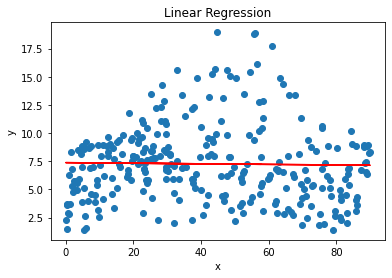

In [157]:
# Northern Hemisphere

linear_regression(northern_hemi_df["Lat"],northern_hemi_df["Wind Speed"])

r-value =  -0.013848722970261134


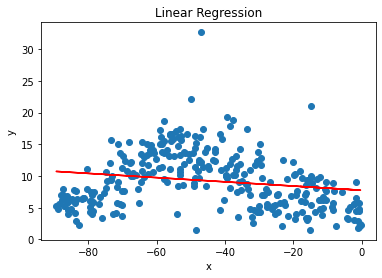

In [158]:
# Southern Hemisphere

linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Wind Speed"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE